In [1]:
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#define amount of sample points
N = 2000

In [43]:
def thermal_conductivity_equation(x):
    return (2 + torch.exp(-4*(torch.pi**2)*x[0])*torch.sin(2*torch.pi*x[1]) + torch.exp(-16*(torch.pi**2)*x[0])*torch.cos(4*torch.pi*x[1]))

# function depicting a real graph and a predicted one
def check_current_situation(cur_model):
    x = torch.linspace(0, 1, 100)
    time = torch.zeros(100)
    real_temp = thermal_conductivity_equation([time, x])

    test_points = torch.stack((time, x), axis = -1)

    pinn_temp = cur_model(test_points)

    plt.plot(x.detach(), pinn_temp.detach())
    plt.plot(x, real_temp)

    plt.plot()
    plt.show()

In [44]:
x_physics = torch.rand(N).requires_grad_(True)
time_physics = 0.05 * torch.rand(N).requires_grad_(True)

points_for_pinn_model = torch.stack((time_physics, x_physics), -1)
boundary_condition_points = torch.stack((torch.zeros(N), x_physics), -1)

torch.manual_seed(123)
thermal_conductivity_equation([time_physics, x_physics])

tensor([2.0817, 2.1821, 1.6635,  ..., 1.0000, 1.7312, 2.3361],
       grad_fn=<AddBackward0>)

In [45]:
#define the class PINN
class PINN(nn.Module):
    def __init__(self, input_layer = 2, hidden_layer = 64, number_layers = 3, output_layer = 1):
        super().__init__()
        
        activation = nn.Tanh
        
        self.fcs = nn.Sequential(*
            [
                nn.Linear(input_layer, hidden_layer),
                activation()
            ]
        )
        
        self.fch = nn.Sequential(*
            [
                nn.Sequential(*
                    [
                        nn.Linear(hidden_layer, hidden_layer),
                        activation()
                    ]
                ) for _ in range(number_layers - 1)
            ]
        )
        
        self.fce = nn.Linear(hidden_layer, output_layer)
        
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        
        return x

In [46]:
pinn_model = PINN()
optimizer = torch.optim.Adam(pinn_model.parameters(), lr=0.003)
#optimizer = torch.optim.Adam(pinn_model.parameters(), lr = 0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5000, gamma=0.5)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor = 0.7)

In [47]:
def adjust_weight(loss1,loss2,loss3):
    """
    Compute weights for three losses
    """
    c1 = 1
    c2 = loss2 / loss1
    c3 = loss3 / loss1
    c1 /= c1 + c2 + c3
    c2 /= c1 + c2 + c3
    c3 /= c1 + c2 + c3
    return c1, c2, c3

epoch: 20000	loss: (7.871067047119141, 3.4778804779052734, 4.39200496673584, 0.001181827043183148)	


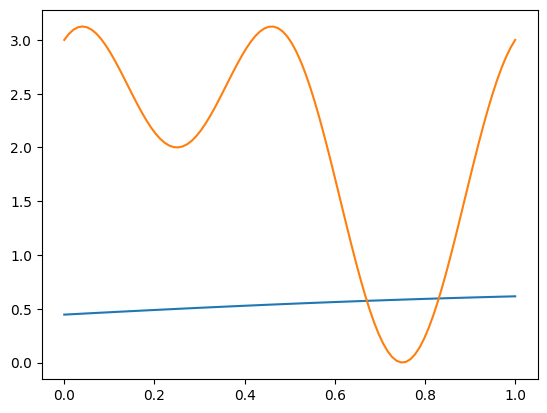

epoch: 20250	loss: (0.8495555520057678, 0.13238473236560822, 0.7166107892990112, 0.000560045416932553)	
epoch: 20500	loss: (0.8250049948692322, 0.12358921021223068, 0.6909806132316589, 0.010435182601213455)	
epoch: 20750	loss: (0.8052579164505005, 0.09703558683395386, 0.6445139050483704, 0.06370840966701508)	
epoch: 21000	loss: (0.8381005525588989, 0.10893140733242035, 0.6518356800079346, 0.07733342051506042)	


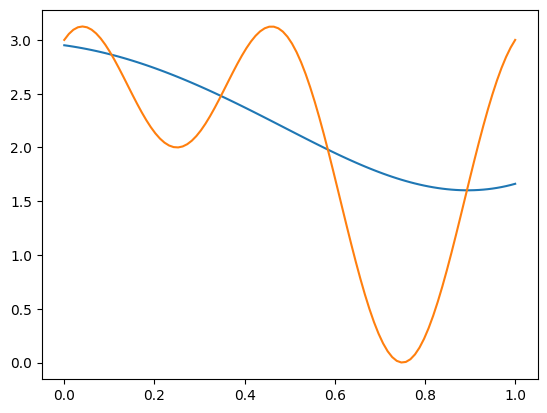

epoch: 21250	loss: (0.6786475777626038, 0.07178675383329391, 0.5865193605422974, 0.020341427996754646)	
epoch: 21500	loss: (0.6342360377311707, 0.06349503248929977, 0.545457661151886, 0.025283334776759148)	
epoch: 21750	loss: (0.7219871282577515, 0.06604405492544174, 0.549378514289856, 0.10656458884477615)	
epoch: 22000	loss: (0.6107738614082336, 0.06795404851436615, 0.5173947811126709, 0.025424998253583908)	


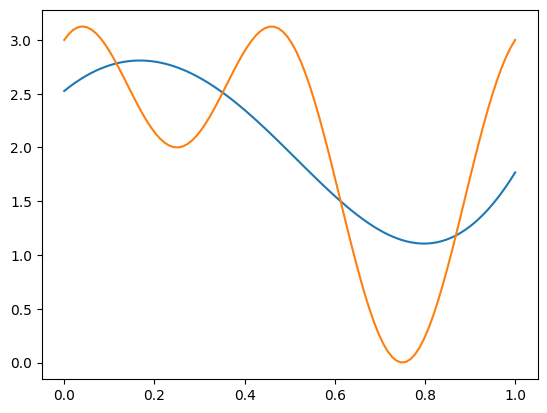

epoch: 22250	loss: (0.6032135486602783, 0.06327822059392929, 0.5164981484413147, 0.02343718335032463)	
epoch: 22500	loss: (0.5927038192749023, 0.06663564592599869, 0.4970228970050812, 0.02904527075588703)	
epoch: 22750	loss: (0.5796093344688416, 0.07139359414577484, 0.4825882911682129, 0.025627439841628075)	
epoch: 23000	loss: (0.5724518895149231, 0.06652875989675522, 0.46969109773635864, 0.036232054233551025)	


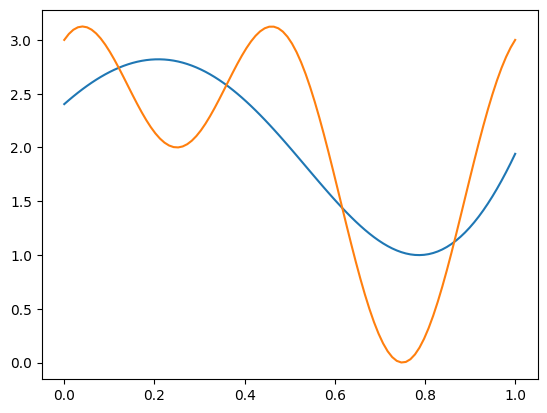

epoch: 23250	loss: (0.6294117569923401, 0.07475022226572037, 0.4437873065471649, 0.1108742207288742)	
epoch: 23500	loss: (0.6508604288101196, 0.051734935492277145, 0.5014916062355042, 0.09763386845588684)	
epoch: 23750	loss: (0.4981444478034973, 0.06196335703134537, 0.4014008045196533, 0.03478030115365982)	
epoch: 24000	loss: (0.5574482083320618, 0.04906301200389862, 0.40014320611953735, 0.1082419604063034)	


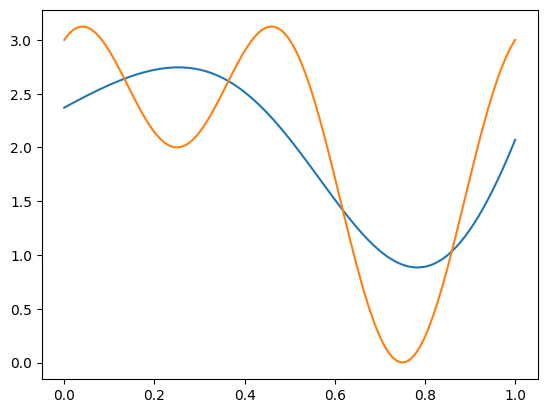

epoch: 24250	loss: (0.47510236501693726, 0.057914286851882935, 0.3405678868293762, 0.0766201838850975)	
epoch: 24500	loss: (0.48309844732284546, 0.05182787775993347, 0.3224290609359741, 0.10884150862693787)	
epoch: 24750	loss: (0.5365670323371887, 0.048766836524009705, 0.28612232208251953, 0.20167787373065948)	
epoch: 25000	loss: (0.561731219291687, 0.04809235408902168, 0.2861483097076416, 0.22749051451683044)	


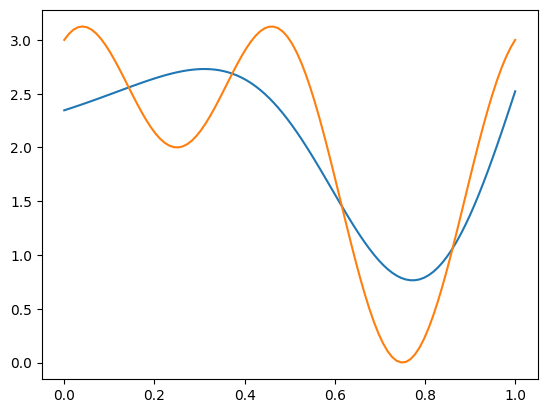

epoch: 25250	loss: (0.6931520700454712, 0.03696133568882942, 0.23172524571418762, 0.42446544766426086)	
epoch: 25500	loss: (0.712855875492096, 0.03875314071774483, 0.21124330163002014, 0.46285945177078247)	
epoch: 25750	loss: (0.49661171436309814, 0.030938414856791496, 0.19854456186294556, 0.26712873578071594)	
epoch: 26000	loss: (0.4963874816894531, 0.039803244173526764, 0.2378310114145279, 0.21875323355197906)	


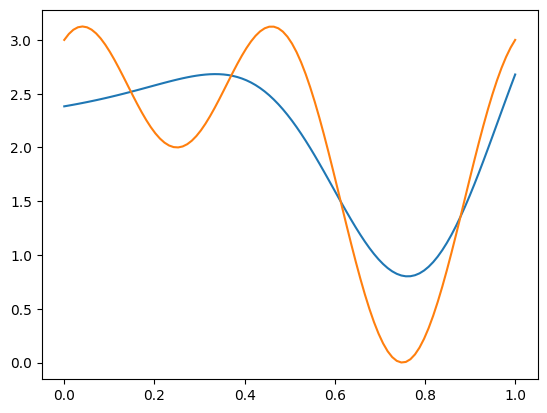

epoch: 26250	loss: (0.24451228976249695, 0.03061147779226303, 0.15227708220481873, 0.061623714864254)	
epoch: 26500	loss: (0.38480520248413086, 0.028168903663754463, 0.13877052068710327, 0.21786577999591827)	
epoch: 26750	loss: (0.7524328827857971, 0.023500660434365273, 0.13003946840763092, 0.5988927483558655)	
epoch: 27000	loss: (0.3286832869052887, 0.024094881489872932, 0.11511114239692688, 0.18947726488113403)	


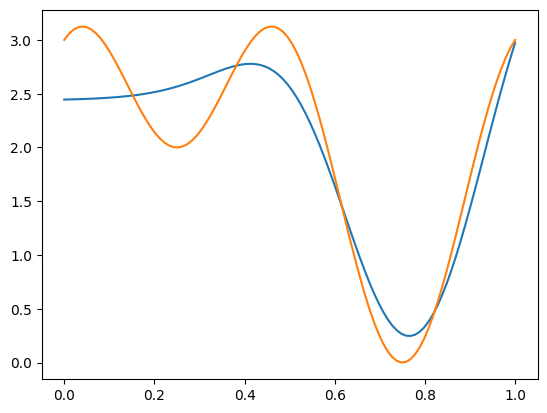

epoch: 27250	loss: (0.18615707755088806, 0.025078117847442627, 0.11370377242565155, 0.04737517982721329)	
epoch: 27500	loss: (0.29195377230644226, 0.021204348653554916, 0.15377388894557953, 0.11697552353143692)	
epoch: 27750	loss: (0.43603527545928955, 0.03644028678536415, 0.20514559745788574, 0.19444939494132996)	
epoch: 28000	loss: (0.32568517327308655, 0.023455413058400154, 0.0900573879480362, 0.21217237412929535)	


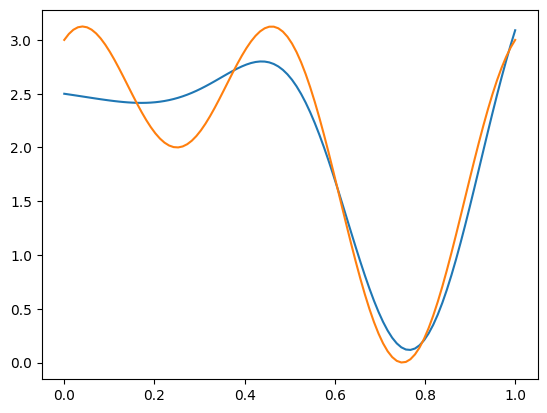

epoch: 28250	loss: (0.15714910626411438, 0.025067750364542007, 0.07835964113473892, 0.05372170731425285)	
epoch: 28500	loss: (0.16804347932338715, 0.02603466436266899, 0.07348734140396118, 0.06852146983146667)	
epoch: 28750	loss: (0.19108891487121582, 0.02416096068918705, 0.08475564420223236, 0.08217231184244156)	
epoch: 29000	loss: (0.12799717485904694, 0.025011835619807243, 0.06661120057106018, 0.03637414053082466)	


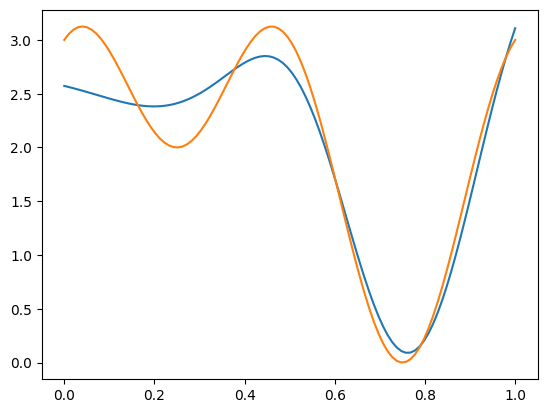

epoch: 29250	loss: (0.4335731863975525, 0.023511745035648346, 0.05941081792116165, 0.3506506383419037)	
epoch: 29500	loss: (0.1959495097398758, 0.022182228043675423, 0.07412312179803848, 0.09964416176080704)	
epoch: 29750	loss: (0.20271214842796326, 0.028972197324037552, 0.06839825958013535, 0.10534169524908066)	
epoch: 30000	loss: (0.11282771080732346, 0.02492297999560833, 0.05306011810898781, 0.03484461456537247)	


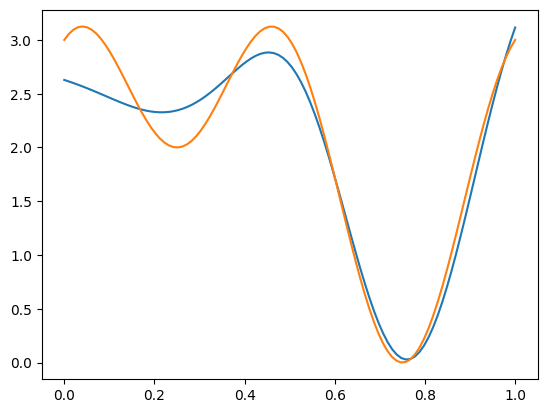

epoch: 30250	loss: (0.21820710599422455, 0.02438703551888466, 0.056290484964847565, 0.13752958178520203)	
epoch: 30500	loss: (0.09935422241687775, 0.027136819437146187, 0.04524705931544304, 0.026970339938998222)	
epoch: 30750	loss: (0.09587300568819046, 0.02707376517355442, 0.04310956224799156, 0.025689678266644478)	
epoch: 31000	loss: (0.09322793036699295, 0.027755167335271835, 0.040261801332235336, 0.02521095983684063)	


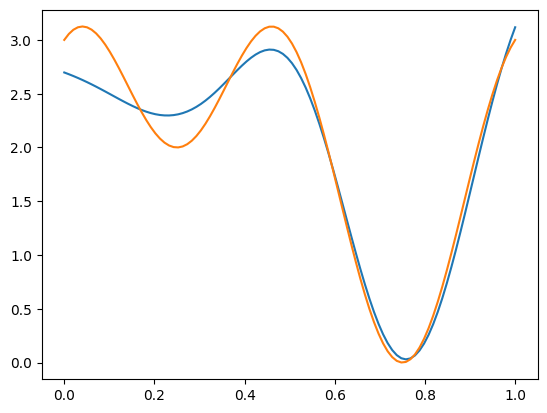

epoch: 31250	loss: (0.09057123214006424, 0.027883486822247505, 0.038360901176929474, 0.02432684786617756)	
epoch: 31500	loss: (0.3290916681289673, 0.03073451668024063, 0.15384802222251892, 0.14450912177562714)	
epoch: 31750	loss: (0.19384421408176422, 0.029335761442780495, 0.09039141982793808, 0.0741170346736908)	
epoch: 32000	loss: (0.4551621377468109, 0.030222516506910324, 0.17634645104408264, 0.24859316647052765)	


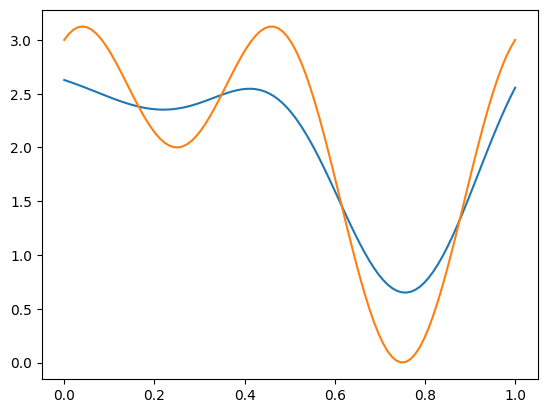

epoch: 32250	loss: (0.10048200190067291, 0.02969679795205593, 0.028864437714219093, 0.04192076995968819)	
epoch: 32500	loss: (0.0792519748210907, 0.028391623869538307, 0.029115863144397736, 0.021744491532444954)	
epoch: 32750	loss: (0.07718713581562042, 0.028813574463129044, 0.027522532269358635, 0.020851029083132744)	
epoch: 33000	loss: (0.07558901607990265, 0.02874218299984932, 0.026601828634738922, 0.020245006307959557)	


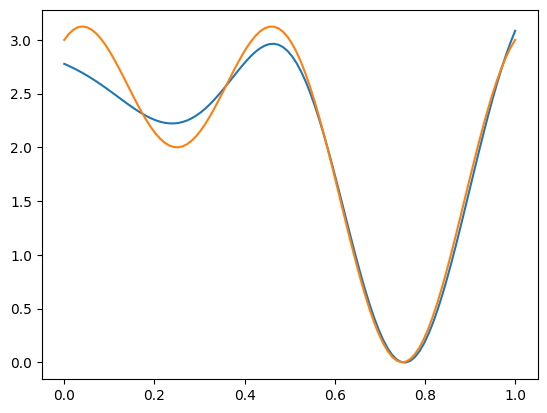

epoch: 33250	loss: (0.07355744391679764, 0.029097383841872215, 0.025182874873280525, 0.019277187064290047)	
epoch: 33500	loss: (0.12482432276010513, 0.029788663610816002, 0.024113768711686134, 0.070921890437603)	
epoch: 33750	loss: (0.3204667568206787, 0.02978231944143772, 0.07880209386348724, 0.2118823379278183)	
epoch: 34000	loss: (0.07222987711429596, 0.027987809851765633, 0.02455504797399044, 0.019687023013830185)	


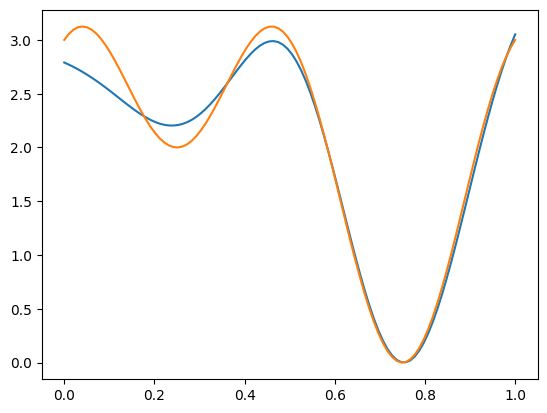

epoch: 34250	loss: (0.06874429434537888, 0.02815716341137886, 0.02287408523261547, 0.017713049426674843)	
epoch: 34500	loss: (0.06731586158275604, 0.028854865580797195, 0.02132536843419075, 0.017135631293058395)	
epoch: 34750	loss: (0.06699105352163315, 0.028890587389469147, 0.020675715059041977, 0.017424751073122025)	
epoch: 35000	loss: (0.07020482420921326, 0.0291244238615036, 0.019811952486634254, 0.0212684515863657)	


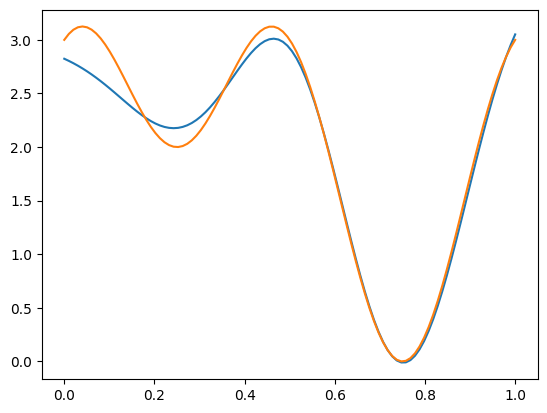

epoch: 35250	loss: (0.09436683356761932, 0.028398890048265457, 0.019328009337186813, 0.04663993790745735)	
epoch: 35500	loss: (0.159021258354187, 0.02730678953230381, 0.02794976718723774, 0.10376469790935516)	
epoch: 35750	loss: (0.12522515654563904, 0.02812100201845169, 0.01974473148584366, 0.07735943049192429)	
epoch: 36000	loss: (0.07355949282646179, 0.029247118160128593, 0.019543057307600975, 0.024769313633441925)	


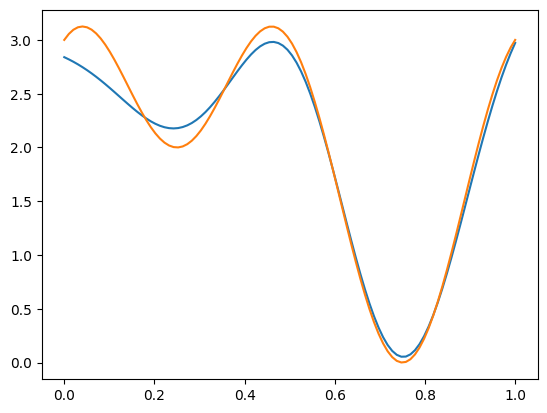

epoch: 36250	loss: (0.08988332748413086, 0.02899319864809513, 0.022093964740633965, 0.03879616782069206)	
epoch: 36500	loss: (0.08887770026922226, 0.028879085555672646, 0.022649405524134636, 0.03734920918941498)	
epoch: 36750	loss: (0.11545053124427795, 0.029074326157569885, 0.016443315893411636, 0.06993288546800613)	
epoch: 37000	loss: (0.5913723111152649, 0.02711901254951954, 0.015218507498502731, 0.5490347743034363)	


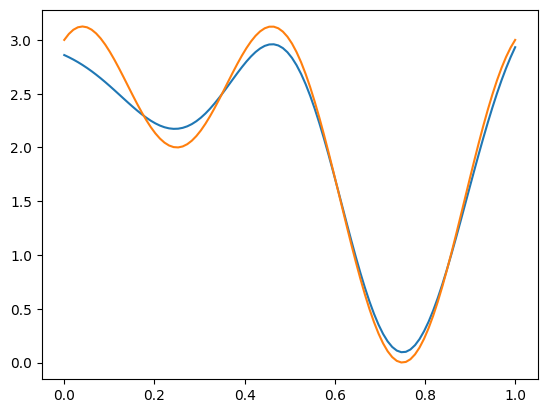

epoch: 37250	loss: (0.11989982426166534, 0.029866468161344528, 0.029711158946156502, 0.060322199016809464)	
epoch: 37500	loss: (0.255171000957489, 0.030452854931354523, 0.013564180582761765, 0.21115395426750183)	
epoch: 37750	loss: (0.09852373600006104, 0.027196751907467842, 0.01609063893556595, 0.055236343294382095)	
epoch: 38000	loss: (0.07030943036079407, 0.02808144874870777, 0.014354337938129902, 0.02787363901734352)	


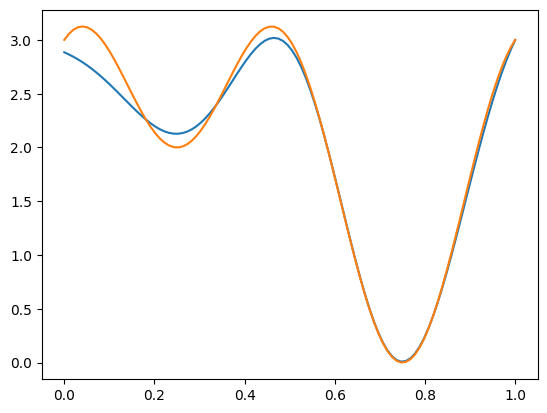

epoch: 38250	loss: (0.20113122463226318, 0.029722807928919792, 0.014249050058424473, 0.15715937316417694)	
epoch: 38500	loss: (0.11773478984832764, 0.027661269530653954, 0.013439386151731014, 0.07663413137197495)	
epoch: 38750	loss: (0.3948676586151123, 0.02800438553094864, 0.08205019682645798, 0.2848130762577057)	
epoch: 39000	loss: (0.06456336379051208, 0.027389945462346077, 0.013577734120190144, 0.023595687001943588)	


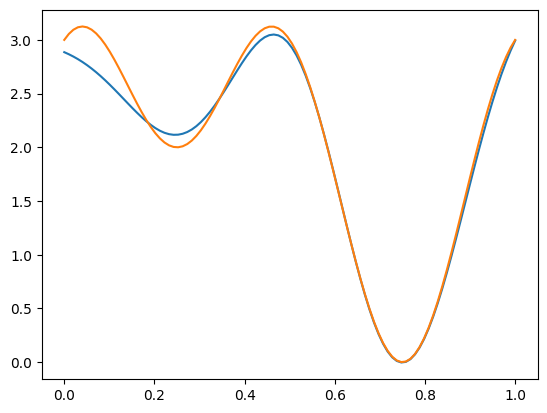

epoch: 39250	loss: (0.05761462450027466, 0.02737022377550602, 0.014678710140287876, 0.015565690584480762)	
epoch: 39500	loss: (0.06056736409664154, 0.027346348389983177, 0.01512532401829958, 0.01809568889439106)	
epoch: 39750	loss: (0.11495280265808105, 0.02655598521232605, 0.020060978829860687, 0.06833583861589432)	


In [48]:
epochs = 20000


for cur_epoch in range(epochs):
    optimizer.zero_grad()
    
    boundary_condition_temp = pinn_model(boundary_condition_points)
    network_temp = pinn_model(points_for_pinn_model)
    
    # compute the "data loss"
    loss1 = torch.mean((thermal_conductivity_equation([time_physics, x_physics]).view(-1,1) - network_temp)**2)
    loss2 = torch.mean((thermal_conductivity_equation([torch.zeros_like(x_physics), x_physics]).view(-1,1) - boundary_condition_temp)**2)
    
    network_temp = pinn_model(points_for_pinn_model)
    
    dt = torch.autograd.grad(network_temp, time_physics, torch.ones_like(network_temp), create_graph=True)[0]

    # computes dy/dx
    dx = torch.autograd.grad(network_temp, x_physics, torch.ones_like(network_temp), create_graph=True)[0]
    
    # computes d^2y/dx^2
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]
    
    # compute the "physics loss"
    loss3 = torch.mean((dt - dx2)**2)
    #c1, c2, c3 = adjust_weight(loss1, loss2, loss3)
    dist = loss1+loss2+loss3
    loss = 0.3*loss1 + 0.5*loss2 + 0.2*loss3 # 0.3 0.6 0.1 - good
    loss.backward(retain_graph=True)
    
    optimizer.step()
    #scheduler.step(loss)
    if cur_epoch % 250 == 0:
        print(f'epoch: {20000+cur_epoch}\tloss: {float(dist.detach().numpy()), float(loss1.detach().numpy()), float(loss2.detach().numpy()), float(loss3.detach().numpy())}\t')
    if cur_epoch % 1000 == 0:
        check_current_situation(pinn_model) 

In [42]:
pinn_model(points_for_pinn_model)

tensor([[2.0062],
        [2.0194],
        [2.0054],
        ...,
        [2.0142],
        [2.0238],
        [2.0115]], grad_fn=<AddmmBackward0>)

In [47]:
torch.mean(thermal_conductivity_equation([time_physics, x_physics]).view(-1,1) - pinn_model(points_for_pinn_model))

tensor(-0.0220, grad_fn=<MeanBackward0>)

In [46]:
thermal_conductivity_equation([time_physics, x_physics]).view(-1,1)


tensor([[2.1422],
        [1.9769],
        [2.2335],
        ...,
        [1.8930],
        [2.6954],
        [1.9622]], grad_fn=<ViewBackward0>)

In [48]:
torch.zeros_like(x_physics)

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [49]:
x_physics

tensor([0.2961, 0.5166, 0.2517,  ..., 0.9463, 0.4930, 0.9744],
       requires_grad=True)

In [18]:
loss

tensor(0.4818, grad_fn=<AddBackward0>)

In [40]:
thermal_conductivity_equation([torch.zeros_like(x_physics), x_physics]).view(-1,1)

tensor([[2.0321],
        [2.5433],
        [1.0441],
        ...,
        [0.6156],
        [0.0254],
        [2.3702]], grad_fn=<ViewBackward0>)

In [42]:
pinn_model(boundary_condition_points) - thermal_conductivity_equation([torch.zeros_like(x_physics), x_physics]).view(-1,1)

tensor([[ 0.2132],
        [-0.1119],
        [ 0.0549],
        ...,
        [ 0.1027],
        [ 0.1308],
        [ 0.1093]], grad_fn=<SubBackward0>)